# True Exit Velocity Project

### Alex Xu

In [2]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib.pyplot import figure
import re
import matplotlib.pyplot as plt
import sqlite3
import datetime
import seaborn as sns
import math
import statsmodels.api as sm 

Question: How do we determine the true exit velocity of a player based on existing exit velocity and launch angle?

## EDA

In [3]:
# Data
batted_balls = pd.read_csv("battedBallData.csv")

In [4]:
batted_balls.head()

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307
1,366,405,ground_ball,60.098403,-54.652102,28.092203,-28.324082
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572


In [5]:
batted_balls.describe()

,batter,pitcher,speed_A,vangle_A,speed_B,vangle_B
count,73375.000000,73375.000000,65803.000000,65803.000000,71973.000000,71973.000000
mean,365.135005,289.957547,88.425429,10.853558,77.748243,13.094305
std,229.816539,186.406565,13.192938,24.024058,18.621538,24.429536
min,1.000000,1.000000,26.461824,-91.898629,5.152318,-85.090929
25%,170.000000,121.000000,80.362652,-5.558918,66.074054,-4.634815
50%,341.000000,283.000000,90.638747,11.005251,81.886750,10.546230
75%,550.000000,447.000000,98.317818,27.404976,92.326944,28.880589
max,816.000000,645.000000,121.847456,78.460978,114.403356,90.900819


In [6]:
batted_balls.groupby(by =['batter'])['speed_A','vangle_A','speed_B','vangle_B'].mean()

,speed_A,vangle_A,speed_B,vangle_B
batter,,,,
1,89.231646,9.396592,77.007720,11.101974
2,81.072924,4.614494,61.125150,15.039281
3,92.482074,9.745586,77.958440,16.339697
4,89.839477,10.062538,77.946913,12.837871
5,88.834383,11.434604,78.832379,15.861496
...,...,...,...,...
812,91.997300,8.636131,81.430736,11.787382
813,93.012396,10.018956,80.662619,13.801358
814,94.928281,9.767290,72.564050,7.147737


In [7]:
batted_balls.groupby(by =['pitcher'])['speed_A','vangle_A','speed_B','vangle_B'].mean()

,speed_A,vangle_A,speed_B,vangle_B
pitcher,,,,
1,89.225561,11.538706,79.581749,15.362999
2,89.908275,13.478619,74.337864,15.843790
3,86.183018,6.049027,73.708689,6.127382
4,87.672225,22.229140,80.942077,23.923707
5,88.769293,10.502851,78.822215,13.270968
...,...,...,...,...
641,82.442202,3.815504,69.226274,3.655727
642,88.585319,14.217996,79.912510,18.331289
643,86.007766,9.474025,78.158328,12.205542


In [8]:
batted_balls.groupby(by =['hittype'])['speed_A','vangle_A','speed_B','vangle_B'].mean()

,speed_A,vangle_A,speed_B,vangle_B
hittype,,,,
U,92.803315,24.403594,75.117881,0.610342
fly_ball,90.058365,35.400101,86.312979,35.703894
ground_ball,86.145805,-10.768739,68.223954,-7.119327
line_drive,92.839124,15.822581,88.744522,15.354946
popup,73.927772,56.119387,71.731057,63.109802


In [9]:
batted_balls.groupby(by =['hittype']).size()

hittype
U                  2
fly_ball       16722
ground_ball    33239
line_drive     18166
popup           5246
dtype: int64

#### Dropping the "U" hit type since the instructions say there are only four types of hit types

In [10]:
batted_balls = batted_balls[batted_balls.hittype != 'U']

### Differences between Systems

In [11]:
# Missing Data
print("Missing rows in System A:",batted_balls['speed_A'].isna().sum())
print("Missing rows in System B:",batted_balls['speed_B'].isna().sum())

Missing rows in System A: 7571
Missing rows in System B: 1402


In [12]:
batted_balls_A = batted_balls.drop(['speed_B','vangle_B'],axis = 1)
batted_balls_B = batted_balls.drop(['speed_A','vangle_A'],axis = 1)

In [13]:
# Split Datasets between System A and B
batted_balls_A.dropna(inplace = True)
batted_balls_B.dropna(inplace = True)

print(len(batted_balls_A))
print(len(batted_balls_B))

65802
71971


In [14]:
# Dataset with measurements from both systems
batted_balls_AB = batted_balls.dropna().copy()

In [15]:
# Metrics to explain the difference between velocity
batted_balls_AB['speed_diff'] = batted_balls_AB['speed_A'] - batted_balls_AB['speed_B']
batted_balls_AB['vangle_diff'] = batted_balls_AB['vangle_A'] - batted_balls_AB['vangle_B']

In [16]:
batted_balls_AB.head()

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B,speed_diff,vangle_diff
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307,7.14500,1.029774
1,366,405,ground_ball,60.098403,-54.652102,28.092203,-28.324082,32.00620,-26.328020
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800,4.91160,0.093051
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274,2.56235,0.689880
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572,5.67630,-0.463810


#### Are the differences in speed and vertical angle between System A and System B statistically significant?

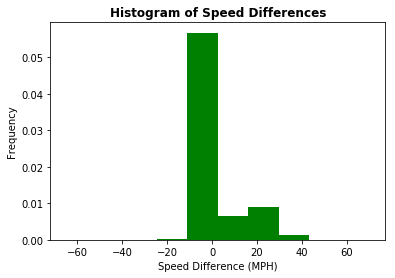

In [17]:
num_bins = 10
   
n, bins, patches = plt.hist(batted_balls_AB['speed_diff'], num_bins, 
                            density = 1, 
                            color ='green',align='left')

plt.xlabel('Speed Difference (MPH)')
plt.ylabel('Frequency')
  
plt.title('Histogram of Speed Differences',
          fontweight ="bold")
  
plt.show()

In [18]:
batted_balls_AB['speed_diff'].describe()

count    64942.000000
mean         8.651598
std          9.838174
min        -58.414730
25%          3.331273
50%          4.181970
75%          6.431025
max         76.960100
Name: speed_diff, dtype: float64

System A more often measures the exit velocity of the batted ball greater than System B, on average of about 8.65 mph higher. To check to see if it is statistically significant:

$$H_0: \mu_1 = \mu_2$$

$$H_A: \mu_1 > \mu_2$$

$$\alpha = .05$$

Sample sizes for both trackers are very large (64942), so we can just treat degrees of freedom as infinite, making the critical value for the one-sided t-test $t_c = 1.645$

We can assume the population variances are equal, and for the sake of brevity, the t-statistic of the two sample means is $102.627$. Therefore we can conclude that the null hypothesis is rejected as $102.627 > t_c$ and that we can accept the alternate hypothesis that the population mean exit velocity of System A is greater than that of System B

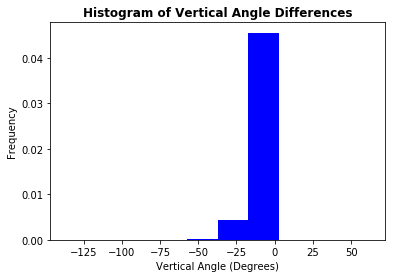

In [19]:
num_bins = 10
   
n, bins, patches = plt.hist(batted_balls_AB['vangle_diff'], num_bins, 
                            density = 1, 
                            color ='blue',align='left')

plt.xlabel('Vertical Angle (Degrees)')
plt.ylabel('Frequency')
  
plt.title('Histogram of Vertical Angle Differences',
          fontweight ="bold")
  
plt.show()

In [20]:
batted_balls_AB['vangle_diff'].describe()

count    64942.000000
mean        -1.629603
std          6.293609
min       -126.844450
25%         -0.908613
50%         -0.040590
75%          0.751888
max         72.238050
Name: vangle_diff, dtype: float64

System A measures the vertical angle of the batted ball as slightly less than System B, although the difference is much less pronounced than it is for speed, on average only a little more than a degree lower.

What about for Vertical Angle?

$$H_0: \mu_1 = \mu_2$$

$$H_A: \mu_1 < \mu_2$$

$$\alpha = .05$$

Sample sizes for both trackers are very large (64942), so we can just treat degrees of freedom as infinite, making the critical value for the one-sided t-test $t_c = 1.645$.

We can assume the population variances are equal, and determine the t-statistic of the two sample means is $\text{-}12.933$. Therefore we can conclude that the null hypothesis is rejected as $|\text{-}12.933| > t_c$ and that we can accept the alternate hypothesis that the population mean vertical angle of System A is less than System B.

Therefore we can conclude that System A measures exit velocity greater and vertical angle slightly lower than System B

#### Examining Outliers

Let's look at some outliers to see if we can determine if there are any additional quirks or anomalies between the two systems, let's define an outlier for both exit velocity and vertical angle as having a difference that is greater than two standard deviations from the mean difference.

For Exit Velocity, the mean difference was $\mu = 8.651598$ with a standard deviation of $s = 9.838174$, this means that any difference outside the range of $(-11.02475,28.327946)$ is considered an outlier.

In [21]:
velocity_outliers = batted_balls_AB[(batted_balls_AB['speed_diff'] < -11.02475) | (batted_balls_AB['speed_diff'] > 28.327946)].copy()

In [22]:
velocity_outliers.groupby(by='hittype').size()

hittype
fly_ball          3
ground_ball    5062
line_drive        5
popup             4
dtype: int64

In [23]:
print("Count of outliers where System A exit velocity was signficantly lower:",len(np.where(velocity_outliers['speed_diff'] < -11.02475)[0]))
print("Count of outliers where System A exit velocity was signficantly higher:",len(np.where(velocity_outliers['speed_diff'] > 28.327946)[0]))

Count of outliers where System A exit velocity was signficantly lower: 48
Count of outliers where System A exit velocity was signficantly higher: 5026


For Vertical Angle, the mean difference was $\mu = -1.629603$ with a standard deviation of $s = 6.293609$, this means that any difference outside the range of $(-14.216822,10.957614)$ is considered an outlier.

In [24]:
vangle_outliers = batted_balls_AB[(batted_balls_AB['vangle_diff'] < -14.216822) | (batted_balls_AB['vangle_diff'] > 10.957614)].copy()

In [25]:
vangle_outliers.groupby(by='hittype').size()

hittype
fly_ball          4
ground_ball    1954
line_drive        7
popup             3
dtype: int64

In [26]:
print("Count of outliers where System A vertical angle was signficantly lower:",len(np.where(vangle_outliers['vangle_diff'] < -14.216822)[0]))
print("Count of outliers where System A vertical angle was signficantly higher:",len(np.where(vangle_outliers['vangle_diff'] > 10.957614)[0]))

Count of outliers where System A vertical angle was signficantly lower: 1928
Count of outliers where System A vertical angle was signficantly higher: 40


We determine now that most of the statistical anomalies come from ground balls, it's possible that ground balls in particular are more difficult for both systems to track, therefore they may not necessarily be as predictive of a player's true exit velocity as flyballs, line drives, and pop-ups.

Also remember that we defined an outlier as having a difference of more than two standard deviations from the mean difference. If we had a less restrictive definition of an outlier such as only one standard deviation, I predict that the additional outliers that we would see are going to mostly be ground balls. 

I think it may be best to eliminate ground balls from our eventual model for both System A and System B, the reasoning behind this is that statistically we've observed that much of the outliers in predictions between the two systems are a result of groundballs which will probably lead to significant noise in any type of regression analysis. In addition, the logic of a ground ball is that it has it has a relatively low vertical launch angle, if we look at the distribution of vertical angle for just ground balls in dataset `batted_balls_AB`:

In [27]:
ground_balls_AB = batted_balls_AB[(batted_balls_AB['hittype'] == 'ground_ball')].copy()

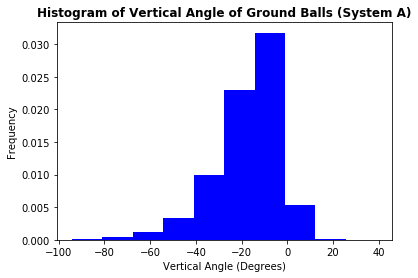

In [28]:
num_bins = 10
   
n, bins, patches = plt.hist(ground_balls_AB['vangle_A'], num_bins, 
                            density = 1, 
                            color ='blue',align='left')

plt.xlabel('Vertical Angle (Degrees)')
plt.ylabel('Frequency')
  
plt.title('Histogram of Vertical Angle of Ground Balls (System A)',
          fontweight ="bold")
  
plt.show()

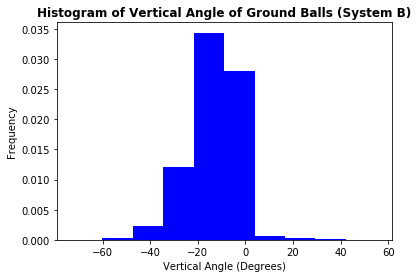

In [29]:
num_bins = 10
   
n, bins, patches = plt.hist(ground_balls_AB['vangle_B'], num_bins, 
                            density = 1, 
                            color ='blue',align='left')

plt.xlabel('Vertical Angle (Degrees)')
plt.ylabel('Frequency')
  
plt.title('Histogram of Vertical Angle of Ground Balls (System B)',
          fontweight ="bold")
  
plt.show()

We can clearly see that the vertical angle is almost always below roughly 10 degrees or so, a ball that is most likely landing somewhere in the infield. Balls that are hit into the ground or straight up in the air are an indication of poor contact that may not necessarily be indicative of a player's true exit velocity when making **solid contact**, and perhaps more importantly, typically don't lead to hits that can produce runs.

#### Case Study:

An example of this is Christian Yelich, a former NL MVP who ranked in the 89th percentile in average exit velocity, 98th! percentile in max exit velocity, and in the 90th percentile for hard hit rate in 2022, yet put up a `wOBA` of $.328$ (88th in league) and `wxOBA` of $.339$ (58th in league), above average but nowhere near his MVP level performance in terms of quality of contact combined with K% and BB%. For additional context his slash line was $.252/.355/.738$ with an $111$ wRC+ and and $2.7$ WAR.


This may seem puzzling, how could a player who hits the ball that hard not be an All-Star hitter or at the very least better than a slightly above average hitter? That is, until you see that Yelich led the NL in groundball percentage (58.6%) and groundball/flyball ratio at 2.95 (245/83) along with finishing last in flyball rate (23.0%). 

In other words, Christian Yelich hit the ball hard, just into the ground.

####  Further Analysis

We can also observe a greater amount of of variance of the exit velocities of ground balls compared to other hits. In addition to being about 4 mph slower on average than other balls, the sample standard deviation of exit velocity for System A groundballs was about 14.49 compared to 11.70 for other batted balls. For System B the difference was greater as ground balls were hit about 15 mph slower than other batted balls, with the standard deviations being 19.36 for ground balls and 11.18 for others.

In [30]:
other_balls_AB = batted_balls_AB[(batted_balls_AB['hittype'] != 'ground_ball')].copy()

In [31]:
ground_balls_AB['speed_A'].describe()

count    28262.000000
mean        86.294078
std         14.493731
min         26.461824
25%         76.753071
50%         88.825014
75%         97.508812
max        121.847456
Name: speed_A, dtype: float64

In [32]:
other_balls_AB['speed_A'].describe()

count    36680.000000
mean        90.219117
std         11.695774
min         35.062166
25%         82.988597
50%         91.891719
75%         98.919813
max        118.811930
Name: speed_A, dtype: float64

In [33]:
ground_balls_AB['speed_B'].describe()

count    28262.000000
mean        71.388659
std         19.361783
min          6.967164
25%         57.399110
50%         70.845973
75%         88.367204
max        114.403356
Name: speed_B, dtype: float64

In [34]:
other_balls_AB['speed_B'].describe()

count    36680.000000
mean        86.386098
std         11.183133
min         32.469336
25%         79.555783
50%         88.007899
75%         94.734958
max        114.398830
Name: speed_B, dtype: float64

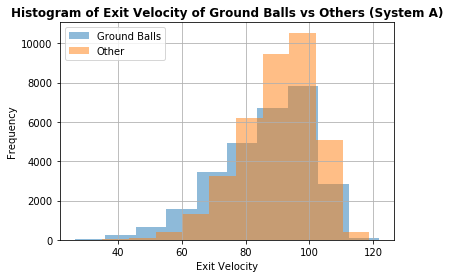

In [35]:
ground_balls_AB['speed_A'].hist(alpha = .5,label ='Ground Balls')
other_balls_AB['speed_A'].hist(alpha = .5,label = 'Other')

plt.legend()

plt.xlabel('Exit Velocity')
plt.ylabel('Frequency')
  
plt.title('Histogram of Exit Velocity of Ground Balls vs Others (System A)',
          fontweight ="bold")
  
plt.show()

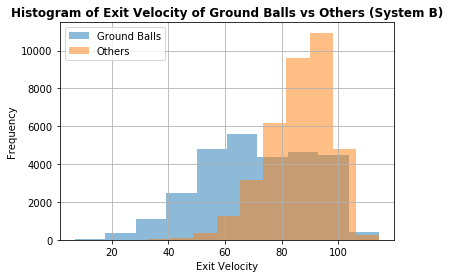

In [36]:
ground_balls_AB['speed_B'].hist(alpha = .5,label ='Ground Balls')
other_balls_AB['speed_B'].hist(alpha = .5, label = 'Others')

plt.legend()

plt.xlabel('Exit Velocity')
plt.ylabel('Frequency')
  
plt.title('Histogram of Exit Velocity of Ground Balls vs Others (System B)',
          fontweight ="bold")
  
plt.show()

Because of this, in order to accurately predict a player's true off-the-bat speed, I believe the best course of action is to project the velocity of their non-groundball hits while adjusting based on their **individual ground ball rate** to avoid overestimating their true exit velocity. In addition, while the definition of a ground ball given is a batted ball that has a negative vertical angle, I believe using the eye-test of the `hittype` column may be more appropriate way to determine if a ball is actually a grounder. This is because a weakly hit ball with an slightly above parallel launch angle can still qualify as a ground ball as it is likely to land *in front* of the infielder. A ball that is hit with a slightly negative or parallel angle can also qualify as a line drive if it is hit hard enough.

## How do we predict true exit velocity?

The reason I felt supervised learning was not appropriate for research question was that I was not attempting to predict another physical metric such as hang-time/distance, or a perfomance statistic such as wxOBA or xSLG. In other words, there wasn't exactly a probabilistic, predictive aspect to the problem in the sense I was using exit velocity and launch angle to predict **something else**, I was using exit velocity and launch angle to find the *true* definition of exit velocity, a definition I needed to justify based on my data exploration and analysis.

Because I suspected that the discrepancies between System A and System B were primarily due to ground balls, which we reasoned not to be indicative of a player's true velocity since they are often the result of poor contact, I first wanted to see if the difference between systems shrank when removing ground balls.

In [37]:
# System difference in speed of all balls
batted_balls_AB['speed_diff'].describe()

count    64942.000000
mean         8.651598
std          9.838174
min        -58.414730
25%          3.331273
50%          4.181970
75%          6.431025
max         76.960100
Name: speed_diff, dtype: float64

In [38]:
# System difference in speed of ground balls
ground_balls_AB['speed_diff'].describe()

count    28262.000000
mean        14.905420
std         12.291907
min        -53.763900
25%          3.567482
50%         12.931260
75%         25.497050
max         76.960100
Name: speed_diff, dtype: float64

In [39]:
# System difference in speed of other balls
other_balls_AB['speed_diff'].describe()

count    36680.000000
mean         3.833019
std          1.264390
min        -58.414730
25%          3.259573
50%          3.880130
75%          4.464278
max         28.234170
Name: speed_diff, dtype: float64

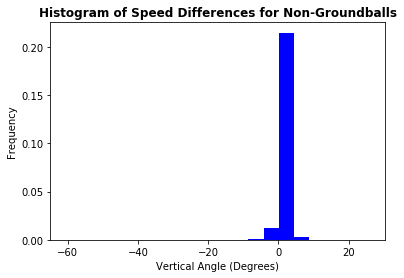

In [40]:
num_bins = 20
   
n, bins, patches = plt.hist(other_balls_AB['speed_diff'], num_bins, 
                            density = 1, 
                            color ='blue',align='left')

plt.xlabel('Vertical Angle (Degrees)')
plt.ylabel('Frequency')
  
plt.title('Histogram of Speed Differences for Non-Groundballs',
          fontweight ="bold")
  
plt.show()

In [41]:
# System difference in vertical angle of ground balls
ground_balls_AB['vangle_diff'].describe()

count    28262.000000
mean        -3.821392
std          9.015245
min       -126.844450
25%         -6.442301
50%         -1.049214
75%          1.179629
max         72.238050
Name: vangle_diff, dtype: float64

In [42]:
# System difference in vertical angle of other balls
other_balls_AB['vangle_diff'].describe()

count    36680.000000
mean         0.059174
std          0.976840
min        -78.293980
25%         -0.426525
50%          0.032150
75%          0.543263
max         14.462580
Name: vangle_diff, dtype: float64

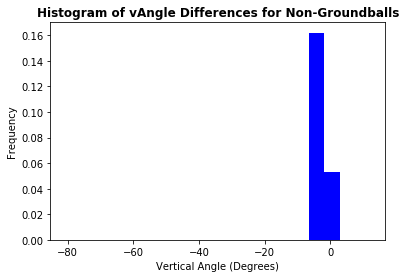

In [43]:
num_bins = 20
   
n, bins, patches = plt.hist(other_balls_AB['vangle_diff'], num_bins, 
                            density = 1, 
                            color ='blue',align='left')

plt.xlabel('Vertical Angle (Degrees)')
plt.ylabel('Frequency')
  
plt.title('Histogram of vAngle Differences for Non-Groundballs',
          fontweight ="bold")
  
plt.show()

Just from splitting the dataset we can already see the discrepancy in differences is mostly due to inaccuracies in ground balls. Therefore in our adjustments between System A and B for **non-groundballs**, we don't need to adjust the speed and velocity of System B nearly as much.

Since we know that System A is much more accurate, but that the difference isn't as stark as we initially saw once we remove ground balls, the criteria that I use for a *true* exit velocity of a non-ground ball was:

`true_velocity_pitch(system_A_speed,system_B_speed){`

`if (Only System A):
    use System A velocity`
    
`if (Only System B):
    use System B velocity adjusted to System A`

`if (System A and System B):
    if (speed_diff greater than 2 standard deviations from average speed_diff):
        use System A velocity
    else:
        take an average velocity of System A and adjusted System B` `}`
                                                            
                                                            
After aggregating the true velocities for each pitch, aggregate the average true velocities for each player and adjust based on individual ground-ball rate based on the average discrepancies between ground-ball and non-ground-ball hits.

`true_adjusted_velocity(average_true_velocity,ground_ball_rate){
    player_true_velocity = average_true_velocity - (player_ground_ball_rate)(ground_ball_adjustment_factor)
    return player_true_velocity }`



I decided the System B speed could be adjusted by adding the the difference in average speed (3.833019), since we observe that System A overestimates speed by that average with a relatively low variance.

In [44]:
avg_speed_diff = 3.833019
speed_diff_std = 1.264390

In [45]:
other_balls = batted_balls[(batted_balls['hittype'] != 'ground_ball')].copy()

In [46]:
other_balls['speed_diff'] = other_balls['speed_A'] - other_balls['speed_B']

In [305]:
# Apply criteria to get true speed of non ground balls
other_balls['true_speed'] = np.where(pd.isnull(other_balls['speed_B']) , other_balls['speed_A'],
                            np.where(pd.isnull(other_balls['speed_A']) , other_balls['speed_B'],
                            np.where((other_balls['speed_diff'] > (avg_speed_diff + 2*speed_diff_std)) | (other_balls['speed_diff'] < (avg_speed_diff - 2*speed_diff_std)),
                                     other_balls['speed_A'], (other_balls['speed_A'] + other_balls['speed_B'] + avg_speed_diff)/2)))



In [248]:
other_balls['true_speed']

2        102.218311
3         62.587425
4        115.769221
7        108.759621
8         81.407472
            ...    
73367     75.447897
73368     82.800685
73372     86.511324
73373     82.335222
73374    101.562249
Name: true_speed, Length: 40134, dtype: float64

In [252]:
batted_balls = batted_balls.join(other_balls['true_speed'])

In [254]:
batted_balls

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B,true_speed
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307,NaN
1,366,405,ground_ball,60.098403,-54.652102,28.092203,-28.324082,NaN
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800,102.218311
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274,62.587425
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572,115.769221
...,...,...,...,...,...,...,...,...
73370,241,144,ground_ball,88.608999,-18.897550,60.251389,-11.486760,NaN
73371,650,615,ground_ball,110.322436,-7.372974,106.029136,-7.702112,NaN
73372,267,615,fly_ball,85.887085,44.557649,83.302545,45.256039,86.511324
73373,797,615,line_drive,81.857912,19.235941,78.979512,18.976781,82.335222


In [306]:
# These code blocks get the percentages of the hittypes
num = batted_balls.groupby(['batter', 'hittype']).size()
denom = batted_balls.groupby(['batter']).size()

In [256]:
hittype_pct = num.div(denom, level = 0, axis = 'index')

In [257]:
out = hittype_pct.to_frame()

In [258]:
# Hittype Percentages
out

0
batter hittype              
1      fly_ball     0.225000
       ground_ball  0.512500
       line_drive   0.225000
       popup        0.037500
2      fly_ball     0.100000
...                      ...
814    line_drive   0.133333
815    ground_ball  1.000000
816    ground_ball  0.571429
       line_drive   0.285714
       popup        0.142857

[2717 rows x 1 columns]

In [263]:
unique_batters = []
for tup in out.index:
    unique_batters.append(tup[0])

unique_batters = set(unique_batters)

In [274]:
# Ground Ball Rates
gb_rates = [] 
for i in unique_batters:
    try: 
        gb_rates.append((i,out.loc[(i,'ground_ball')].iloc[0]))
    except:
        gb_rates.append((i,0.0))

In [280]:
idx, values = zip(*gb_rates)

gb_series = pd.Series(values, idx)

In [261]:
# Total At-Bats for each batter
batter_at_bats = batted_balls.groupby('batter').size()

In [259]:
# Batter average velocity
batter_avg_speed = batted_balls.groupby('batter')['true_speed'].mean()

In [312]:
frame = {'at_bats':batter_at_bats,'avg_speed':batter_avg_speed,'groundball_rate':gb_series}
batter_agg_data = pd.DataFrame(frame)

In [313]:
batter_agg_data

,at_bats,avg_speed,groundball_rate
1,80,87.916712,0.512500
2,20,79.344998,0.650000
3,9,81.437586,0.555556
4,145,92.176205,0.482759
5,108,89.088019,0.462963
...,...,...,...
812,61,93.463998,0.557377
813,14,98.403734,0.357143
814,30,94.701536,0.666667
815,9,NaN,1.000000


Now that we have the average speed of non-groundballs as well as the average ground ball rate we can project what a player's true velocity.

First we drop `NaN` values since this means that the player hit nothing but ground balls and we cannot accurately assess their true velocity.

In [314]:
batter_agg_data.dropna(inplace=True)

We also remove rows with less than 10 at bats where contact was made so that we get a large enough number of samples to get an accurate prediction.

In [315]:
indexABs = batter_agg_data[ (batter_agg_data['at_bats'] <= 10)].index
batter_agg_data.drop(indexABs , inplace=True)

Lastly, we need to find the average difference in velocity between ground balls and other contact across the whole dataset to see how much we subtract from a player's velocity on non-ground ball hits, for simplicity we can use System A since we know there are issues with System B's tracking of ground balls. We find across the entire dataset, there is a difference of 4.037235 mph between grounders and non-grounders. In other words, MLB players hit ground balls 4.037235 mph slower on average.

In [316]:
batted_balls_gb = batted_balls[(batted_balls['hittype'] == 'ground_ball')].copy()
batted_balls_gb['speed_A'].describe()

count    28648.000000
mean        86.145805
std         14.594343
min         26.461824
25%         76.542640
50%         88.677389
75%         97.444006
max        121.847456
Name: speed_A, dtype: float64

In [317]:
batted_balls_other = batted_balls[(batted_balls['hittype'] != 'ground_ball')].copy()
batted_balls_other['speed_A'].describe()

count    37154.000000
mean        90.183040
std         11.702149
min         35.062166
25%         82.924546
50%         91.849189
75%         98.889056
max        118.811930
Name: speed_A, dtype: float64

To finally get our true velocity we can use the equation we outlined earlier:

$$\text{True Velocity} = \text{(Avg Velocity Non-Ground Balls)} - (\text{Player Ground Ball Rate})(\text{Avg Speed Difference of GB vs. Non-GB})$$

In [318]:
avg_diff = 4.037235 
batter_agg_data['true_velocity'] = batter_agg_data['avg_speed'] - batter_agg_data['groundball_rate']*(avg_diff)

In [319]:
batter_agg_data

,at_bats,avg_speed,groundball_rate,true_velocity
1,80,87.916712,0.512500,85.847629
2,20,79.344998,0.650000,76.720795
4,145,92.176205,0.482759,90.227195
5,108,89.088019,0.462963,87.218929
6,413,85.787089,0.617433,83.294365
...,...,...,...,...
810,40,86.862587,0.450000,85.045831
811,280,92.632942,0.539286,90.455719
812,61,93.463998,0.557377,91.213736
813,14,98.403734,0.357143,96.961864


## Discussion

While we observe that ground balls are hit at a lower velocity than line drive, pop-ups, and flyouts, we also acknowledge that they do play a role in determining a player's true velocity which is why we made the adjustments that we did. This also helped us adjust between the differences between Systems A and B once we realized the biggest discrepencies were from ground-balls, which System B seemed to be more inaccurate in tracking.

In further work building upon this project I'd be very interested in seeing each player's metrics for hitting beyond OPS such as wxOBA or xOBP. As we saw in the brief analysis of a player with excellent *overall* exit velocity, we saw that he somewhat underperformed his expected performance based on exit velocity as he hit the ball at a high rate into the ground. One additional consideration I would've liked to discuss with others is if there were a better way of adjusting the ground-ball factor in the last step. I would have also liked to try my hand at an unsupervised learning technique such as clustering to investigate the relationship between launch angle and exit velocity, while we know that launch angles that are greater than 0 but not too high are what generally lead to more power and more hits, it would've been interesting to see if we could discern any patterns between the two factors. However, I realize that this project is meant to be completed in about 4 hours and I did not feel I could complete all the analysis I would've been interested in reasonably within the expected time.

### Citations

- https://pandas.pydata.org/docs/index.html
- https://matplotlib.org/stable/index.html
- https://www.statsmodels.org/stable/index.html
- https://tht.fangraphs.com/improving-projections-with-exit-velocity/
- https://blogs.fangraphs.com/you-cant-fake-exit-velocity/
- https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby